### Notebook to genereate mean vertical profiles from TC output

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
4/23/22

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
from thermo_functions import density_moist, theta_dry, theta_equiv, theta_virtual, relh
from stratiform_index import stratiform_index

#### Time selection

In [2]:
nt=24
t0 = 48
t1 = t0+nt

xmin=780

#### Directories

In [3]:
figdir = "/Users/jruppert/code/tc_figs/"

# main = "/Users/jamesruppert/code/tc_output/"
main = "/Users/jruppert/code/tc_output/"
storm = !ls $main
# print(storm)

istorm=storm[0]
memb = !ls $main/$istorm
imemb=memb[0]
# print(main+istorm+'/'+imemb)

datdir = main+istorm+'/'+imemb+'/ctl/'
print(datdir)

/Users/jruppert/code/tc_output/haiyan/memb_01/ctl/


#### Read variables

In [4]:
# Two-dimensional variables

# Conv/strat separation: varout = 1 if convective, = 2 if stratiform, = 3 other, = 0 if no rain
varfil_strat = Dataset(datdir+'strat.nc') # this opens the netcdf file
strat = varfil_strat.variables['strat'][t0:t1,:,:,xmin:1400-1]
varfil_strat.close()

# PW
binfil = Dataset(datdir+'PW.nc') # this opens the netcdf file
pw = binfil.variables['PW'][t0:t1,:,:,xmin:1400-1]
binfil.close()

# LW-ACRE
binfil = Dataset(datdir+'LWacre.nc') # this opens the netcdf file
lwacre = binfil.variables['LWUPB'][t0:t1,:,:,xmin:1400-1] # W/m2
binfil.close()

# Rainfall
binfil = Dataset(datdir+'rainrate.nc') # this opens the netcdf file
rain = binfil.variables['rainrate'][t0:t1,:,:,xmin:1400-1] # mm/hr
binfil.close()

# For density
# fil = Dataset(datdir+'T.nc')
# tmpk = fil.variables['T'][t0:t1,:,:,:] # K
# fil.close()
# fil = Dataset(datdir+'QVAPOR.nc')
# qv = fil.variables['QVAPOR'][t0:t1,:,:,:] # kg/kg
# fil.close()

In [5]:
# Three-dimensional variables

# Vertical coordinate
filtmp = Dataset(datdir+'RTHRATLW.nc')
pres = filtmp.variables['pres'][:] # hPa
print("Vertical shape: ",np.shape(pres))
filtmp.close()

# Mixing ratio
varfil_main = Dataset(datdir+'QVAPOR.nc')
qv = varfil_main.variables['QVAPOR'][t0:t1,:,:,xmin:1400-1] # kg/kg
varfil_main.close()
units_var1 = 'kg/kg'

# Horizontal temperature anomaly
varfil_main = Dataset(datdir+'T.nc')
tmpk = varfil_main.variables['T'][t0:t1,:,:,xmin:1400-1] # K
varfil_main.close()
thp = theta_virtual(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # K
units_thp = 'K'
# Subtract time-dependent domain average
t_mean = np.mean(np.mean(thp,axis=3),axis=2)
thp -= t_mean[:,:,np.newaxis,np.newaxis]

# Equiv pot temp
th_e = theta_equiv(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # K
# Subtract time-dependent domain average
t_mean = np.mean(np.mean(th_e,axis=3),axis=2)
th_e -= t_mean[:,:,np.newaxis,np.newaxis]

bv_shape = np.shape(tmpk)
print("Binvar shape: ",bv_shape)
nt = bv_shape[0]
nz = bv_shape[1]
nx1 = bv_shape[2]
nx2 = bv_shape[3]

Vertical shape:  (10,)
Binvar shape:  (24, 10, 740, 619)


In [6]:
# Vertical motion
varfil_cvar = Dataset(datdir+'W.nc') # this opens the netcdf file
w = varfil_cvar.variables['W'][t0:t1,:,:,xmin:1400-1] # m/s
rho = density_moist(tmpk,qv,pres[np.newaxis,:,np.newaxis,np.newaxis]*1e2)
print(rho[5,:,30,30])
varfil_cvar.close()
binvar_c_in = w*1e2 # m/s --> cm/s
units_var2='cm/s'
lcmin = -20; lcmax=20; lcint=2

[1.1404595375061035 1.054334044456482 0.9567867517471313
 0.8568334579467773 0.7532491087913513 0.6474683284759521
 0.5395930409431458 0.4295923411846161 0.31807753443717957
 0.17812390625476837]


#### Calculate VMF

In [7]:
# Vmf in lower and upper trop
dp = 10000. # Pa
g = 9.81 # m/s2
ktop1=500
ktop2=100
iktop1 = np.where(pres == ktop1)[0][0]
iktop2 = np.where(pres == ktop2)[0][0]

# Layer VMF = -1/g SUM(w * dp) = m/s * s**2/m * kg/m/s**2 = kg/s/m
vmf_lower = np.mean(w[:,0:iktop1,:,:],1) * dp/g
vmf_upper = np.mean(w[:,iktop1:iktop2,:,:],1) * dp/g
vmf_lower = np.reshape(vmf_lower,(nt,1,nx1,nx2))
vmf_upper = np.reshape(vmf_upper,(nt,1,nx1,nx2))
vmf = vmf_lower + vmf_upper
vmf_th = (vmf_upper - vmf_lower) / vmf

#### New conv/strat index

In [8]:
# strat2 = stratiform_index(rain,vmf_lower,vmf_upper,verbose=0)

#### Average for Conv, Strat, and Anvil

In [9]:
indices_s = ((strat == 2) & (pw >= 55)).nonzero()
indices_c = ((strat == 1) & (pw >= 55)).nonzero()
# indices_s = ((strat2 == 2) & (pw >= 55)).nonzero()
# indices_c = ((strat2 == 1) & (pw >= 55)).nonzero()

thresh_raining = 1e1 # mm/hr
indices_rain = (rain > thresh_raining).nonzero()

w_s=np.zeros(nz)
w_c=np.zeros(nz)
w_mn=np.zeros(nz)

thp_s=np.zeros(nz)
thp_c=np.zeros(nz)
the_s=np.zeros(nz)
the_c=np.zeros(nz)

# w_mn = np.mean(w,axis=(0,2,3),dtype=np.float64)

for iz in range(nz):
    w_s[iz] = np.mean(w[indices_s[0],iz,indices_s[2],indices_s[3]],dtype=np.float64)
    w_c[iz] = np.mean(w[indices_c[0],iz,indices_c[2],indices_c[3]],dtype=np.float64)
    w_mn[iz] = np.mean(w[indices_rain[0],iz,indices_rain[2],indices_rain[3]],dtype=np.float64)
    thp_s[iz] = np.mean(thp[indices_s[0],iz,indices_s[2],indices_s[3]],dtype=np.float64)
    thp_c[iz] = np.mean(thp[indices_c[0],iz,indices_c[2],indices_c[3]],dtype=np.float64)
    the_s[iz] = np.mean(th_e[indices_s[0],iz,indices_s[2],indices_s[3]],dtype=np.float64)
    the_c[iz] = np.mean(th_e[indices_c[0],iz,indices_c[2],indices_c[3]],dtype=np.float64)

---
### Plotting routines

In [11]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

### Plot profiles

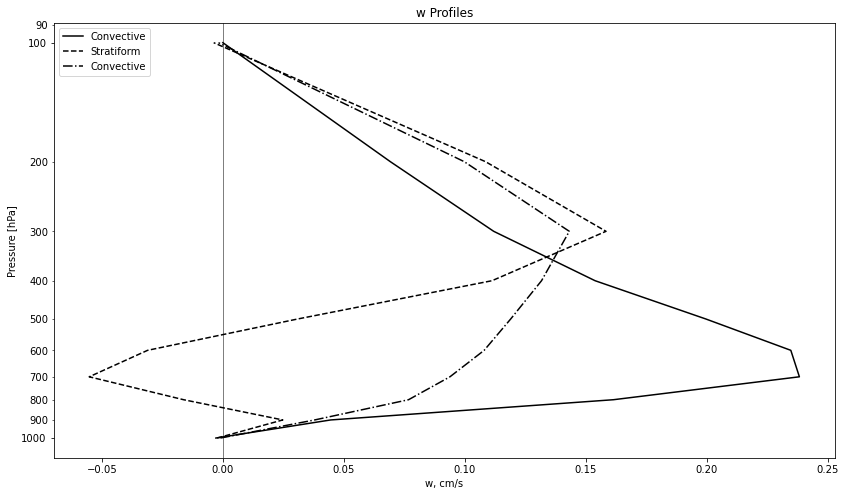

In [12]:
# create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title('w Profiles')
ax.set_ylabel('Pressure [hPa]')

ax.invert_yaxis()
ax.set_yscale('log')

plt.plot(w_c/8, pres, "-k", label="Convective")
plt.plot(w_s, pres, "--k", label="Stratiform")
plt.plot(w_mn, pres, "-.k", label="Convective")

ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

plt.axvline(x=0,color='k',linewidth=0.5)
ax.set_xlabel('w, '+units_var2)
# plt.xlim(np.min(bins), np.max(bins))
plt.legend(loc="upper left")

plt.show()
# plt.savefig(figdir+figtag+'_compcross_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)

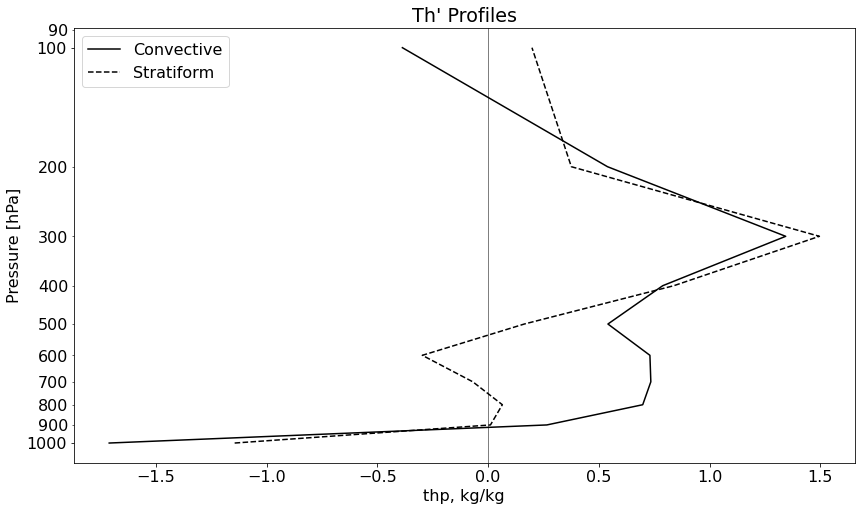

In [18]:
# create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title("Th' Profiles")
ax.set_ylabel('Pressure [hPa]')

ax.invert_yaxis()
ax.set_yscale('log')

plt.plot(thp_c, pres, "-k", label="Convective")
plt.plot(thp_s, pres, "--k", label="Stratiform")

ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

plt.axvline(x=0,color='k',linewidth=0.5)
ax.set_xlabel('thp, '+units_var1)
plt.legend(loc="upper left")

plt.show()
# plt.savefig(figdir+figtag+'_compcross_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)

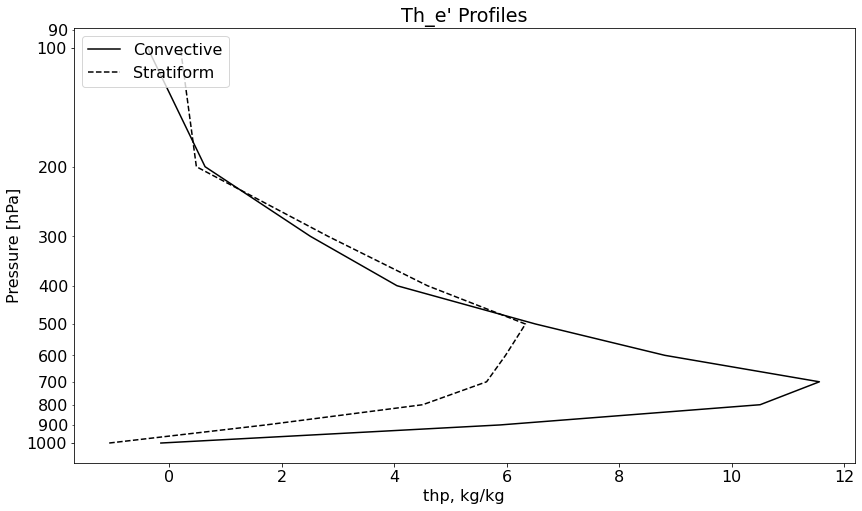

In [19]:
# create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title("Th_e' Profiles")
ax.set_ylabel('Pressure [hPa]')

ax.invert_yaxis()
ax.set_yscale('log')

plt.plot(the_c, pres, "-k", label="Convective")
plt.plot(the_s, pres, "--k", label="Stratiform")

ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

# plt.axvline(x=0,color='k',linewidth=0.5)
ax.set_xlabel('thp, '+units_var1)
plt.legend(loc="upper left")

plt.show()
# plt.savefig(figdir+figtag+'_compcross_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)